In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt
import tqdm
import matplotlib
import textwrap

fig_path = '/home/fgrymula/figures/'
sns.set(style="darkgrid")

preprocessing

In [10]:
dataset = pd.read_csv("/home/bjastrze/Projects/NTU/data/all_observations.tsv", sep='\t', parse_dates=True)
dataset.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
dataset.to_csv("/home/fgrymula/data/all_observations_old.tsv", sep='\t', index=False)

In [12]:
audio_features = ['Active teacher stands by slides and explains them',
            'Laughter',
            'Asking questions',
            'Referring to bibliography, other researchers',
            'Session on tests',
            'Giving hints how to do something',
            'Giving questions to students: rhetorical, comprehension questions',
            'Organization: giving class outline, clearly indicating transition from one topic to another',
            'Summing up',
            'Use of voice intonation to emphasise more important issues/topics']
audio_features_with_n = dict(zip(audio_features, ['Active teacher stands by slides and explains them',
            'Laughter',
            'Asking questions',
            'Referring to bibliography, other researchers',
            'Session on tests',
            'Giving hints how to do something',
            'Giving questions to students: rhetorical, comprehension questions',
            'Organization: giving class outline, clearly\nindicating transition from one topic to another',
            'Summing up',
            'Use of voice intonation to emphasise more important issues/topics']))

dataset = pd.read_csv("/home/fgrymula/data/all_observations_old.tsv", sep='\t', parse_dates=True)
dataset.rename(columns={'Start (s)': 'Start', 'Stop (s)': 'Stop', 'Duration (s)': 'Duration',
                        'Behavioral category': 'Behavior category'}, inplace=True)
dataset.drop(columns=['Comment start', 'Comment stop'], inplace=True)

# Treat state and point as the same
remove = ['S, ', 'P, ']
for r in remove:
    dataset.loc[dataset['Behavior'].str.startswith(r), 'Behavior'] = dataset[dataset['Behavior'].str.startswith(r)]['Behavior'].str[len(r):]
# get video name
dataset['video name'] = dataset['Media file'].str.split('/').apply(lambda x: x[-1])
#dataset['Behavior'] = dataset['Behavior'].apply(lambda x: audio_features_with_n.get(x, x))
dataset.loc[dataset['Behavior category'].str.startswith('Setting'), 'Behavior category'] = \
"Setting expectations and routines; Establishing interaction and raport; Determining lessons\nobjectives; Deciding on teaching aids and learning resources; Pacing and maintaing momentum"

# merge duplicate behaviors
beh_old = 'organization: giving class outline, clearly indicating Transition from one topic to another"'
beh_new = beh_old[:-1]
dataset.loc[dataset['Behavior'] == beh_old, 'Behavior'] = beh_new
beh_old = 'giving questions to students: rhetorical, comprehension questions", point each question'
beh_new = 'giving questions to students: rhetorical, comprehension questions'
dataset.loc[dataset['Behavior'] == beh_old, 'Behavior'] = beh_new
# capitalize Behavior names
dataset['Behavior'] = dataset['Behavior'].str.lower().str.capitalize()

dataset.to_csv("/home/fgrymula/data/all_observations.tsv", sep='\t', index=False)
dataset = pd.read_csv("/home/fgrymula/data/all_observations.tsv", sep='\t', parse_dates=True)
dataset_audio = dataset.loc[dataset['Behavior'].isin(audio_features)]
dataset_audio.to_csv("/home/fgrymula/data/observations_audio.tsv", sep='\t', index=False)

Join metrics with audio dataset

In [43]:
metrics = pd.read_csv('/home/fgrymula//data/complete_observations_with_metrics.csv')
df = pd.merge(dataset_audio, metrics.loc[:, ['feature_iou', 'lecture_iou', 'ra_iou']],
              how='left', left_on='id', right_index=True)

df.to_csv('/home/fgrymula/data/observations_audio.tsv', index=False)

In [58]:
for col in dataset_audio.columns:
    print(f'\item {col}')

\item Behavior
\item Behavior type
\item Behavior category
\item Duration
\item FPS
\item Media file
\item Modifiers
\item Observation date
\item Observation id
\item Start
\item Stop
\item Subject
\item Total length
\item lecture_id
\item research_assistant_id
\item subject_id
\item video name


EDA

## audio

In [2]:
dataset_audio = pd.read_csv('/home/fgrymula/data/observations_audio.tsv')

In [82]:
df = dataset_audio.groupby('Behavior') \
    .agg(Count=('Observation id', 'count'), Duration=('Duration', np.nansum)) \
    .sort_values('Count', ascending=False) \
    .reset_index()
beh_abbreviated = ['AQ', 'GQ', 'O', 'S', 'AT', 'L', 'U', 'SU', 'R', 'GH']
df.loc[:, 'Behavior'] = [beh + f' ({abb})' for beh, abb in zip(df['Behavior'], beh_abbreviated)]
df.loc[:, 'share'] = list(map(lambda x: str(x) + '%',
                                      np.round(df['Duration'] / sum(df['Duration']) * 100, 2)))
df

Behavior  Count    Duration  \
0                              Asking questions (AQ)   4926   64801.394   
1  Giving questions to students: rhetorical, comp...   3616   17053.753   
2  Organization: giving class outline, clearly in...   1211   41672.434   
3                               Session on tests (S)    854  131106.680   
4  Active teacher stands by slides and explains t...    835  719970.553   
5                                       Laughter (L)    315    1861.351   
6  Use of voice intonation to emphasise more impo...    200    1101.679   
7                                    Summing up (SU)     72    8652.605   
8   Referring to bibliography, other researchers (R)     55    2279.985   
9              Giving hints how to do something (GH)     12     115.020   

    share  
0   6.55%  
1   1.73%  
2   4.22%  
3  13.26%  
4  72.83%  
5   0.19%  
6   0.11%  
7   0.88%  
8   0.23%  
9   0.01%

In [90]:
dd = df.copy()
dd.loc[:, 'Abb'] = beh_abbreviated
dd.loc[:, 'Duration'] = dd['Duration'].round(0).astype(int)
dd.loc[:, 'Behavior'] = dd['Behavior'].apply(lambda s: s[:s.find(' (')])
print(dd.iloc[:, [0, -1, 1, 2, 3]].to_latex(index=False))

\begin{tabular}{llrrl}
\toprule
                                          Behavior & Abb &  Count &  Duration &   share \\
\midrule
                                  Asking questions &  AQ &   4926 &     64801 &   6.55\% \\
 Giving questions to students: rhetorical, comp... &  GQ &   3616 &     17054 &   1.73\% \\
 Organization: giving class outline, clearly in... &   O &   1211 &     41672 &   4.22\% \\
                                  Session on tests &   S &    854 &    131107 &  13.26\% \\
 Active teacher stands by slides and explains them &  AT &    835 &    719971 &  72.83\% \\
                                          Laughter &   L &    315 &      1861 &   0.19\% \\
 Use of voice intonation to emphasise more impo... &   U &    200 &      1102 &   0.11\% \\
                                        Summing up &  SU &     72 &      8653 &   0.88\% \\
      Referring to bibliography, other researchers &   R &     55 &      2280 &   0.23\% \\
                  Giving hints how to do

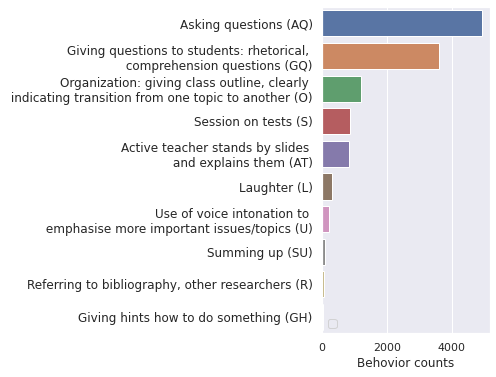

In [51]:
def format_ylabel(s):
    x = s.split()
    if len(x) >= 8:
        s = ' '.join(x[:5] + ['\n'] + x[5:])
    return s

sns.set(font_scale=1) 

#max_width=5
f, ax = plt.subplots(figsize=(3, 6))
g = sns.barplot(data=df, x='Count', y='Behavior', hue='Behavior', dodge=False)
#g.set_yticks(g.get_yticks().tolist())
#g.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
#g.legend(loc='lower right', bbox_to_anchor=(1, 1))
g.legend('')
ylabels = [ format_ylabel(s.get_text()) for s in g.get_yticklabels() ]
g.set_yticklabels(labels=ylabels, size=12)
g.set_ylabel('')
g.set_xlabel('Behovior counts')
plt.savefig(fig_path + 'behaviors_bar.png', dpi=500, bbox_inches='tight')

Duration

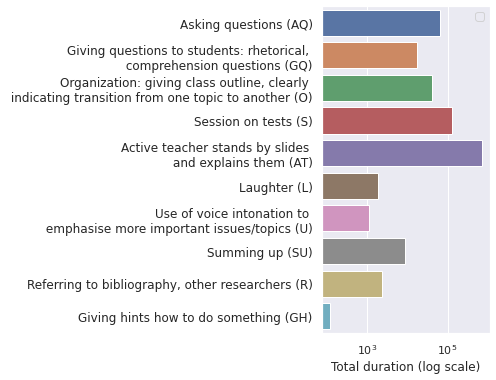

In [52]:
def format_ylabel(s):
    x = s.split()
    if len(x) >= 8:
        s = ' '.join(x[:5] + ['\n'] + x[5:])
    return s

sns.set(font_scale=1) 

#max_width=5
f, ax = plt.subplots(figsize=(3, 6))
g = sns.barplot(data=df, x='Duration', y='Behavior', hue='Behavior', dodge=False)
#g.set_yticks(g.get_yticks().tolist())
#g.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
#g.legend(loc='lower right', bbox_to_anchor=(1, 1))
g.legend('')
g.set_xscale("log")
ylabels = [ format_ylabel(s.get_text()) for s in g.get_yticklabels() ]
g.set_yticklabels(labels=ylabels, size=12)
g.set_ylabel('')
g.set_xlabel('Total duration (log scale)')
plt.savefig(fig_path + 'behavior_duration.png', dpi=500, bbox_inches='tight')

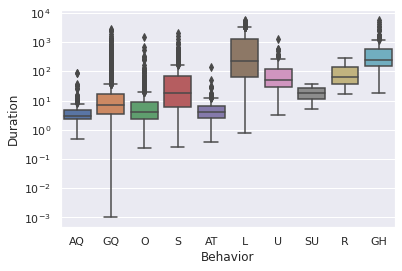

In [54]:
df = dataset_audio
g = sns.boxplot(data=df, y='Duration', x='Behavior')
g.set_yscale("log")
g.set(xticklabels=beh_abbreviated)
plt.savefig(fig_path + 'duration_box.png', dpi=500)

In [59]:
def is_overlapping(start0, stop0, start1, stop1):
    return start0 <= start1 <= stop0 or start1 <= start0 <= stop1

df = dataset_audio
start = df['Start'].values.tolist()
stop = df['Stop'].values.tolist()
video_name = df['video name'].values.tolist()

overlapping = []
for idx0, (start0, stop0, vid0) in tqdm.tqdm(enumerate(zip(start, stop, video_name)), total=len(start)):
    n_overlapping = 1
    for idx1, (start1, stop1, vid1) in enumerate(zip(start, stop, video_name)):
        if idx0 < idx1 and vid0 == vid1:
            n_overlapping += is_overlapping(start0, stop0, start1, stop1)
    overlapping.append(n_overlapping)
df = df.assign(n_overlapping=overlapping)

100%|██████████| 12096/12096 [00:46<00:00, 258.17it/s]


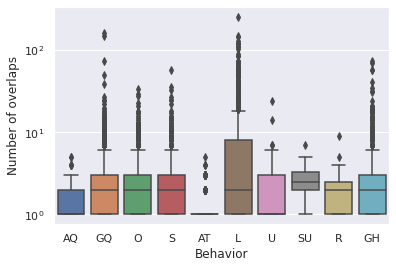

In [61]:
g = sns.boxplot(data=df, y='n_overlapping', x='Behavior')
g.set_yscale("log")
#g.set(ylim=(0, 300))
g.set(xticklabels=beh_abbreviated)
g.set_ylabel('Number of overlaps')
plt.savefig(fig_path + 'n_overlapping_box.png', dpi=500)